In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
# Using seaborn's style
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": False,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}

plt.rcParams.update(nice_fonts)

width = 418.25368
def set_size(width=width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

## Load data

In [3]:
def get_data():
    columns = np.load("data/data_columns.npy")
    X = np.load("data/data_valence_physio_with_pupil_for_svm_only_valid_session.npy")
    Y = np.load("data/data_valence_label_with_pupil_for_svm_only_valid_session.npy")
    return pd.DataFrame(X, columns=columns), pd.DataFrame(Y)

In [4]:
X, Y = get_data()
#X = X.drop(["SKT_mean_abs_diff", "SKT_std"], axis=1)
print X.shape
print Y.shape

(82400, 25)
(82400, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f708d284850>]],
      dtype=object)

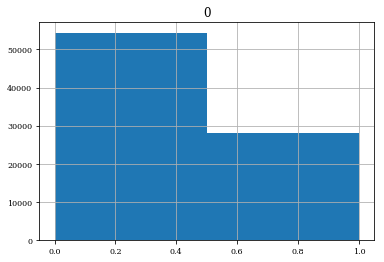

In [5]:
# binarize the problem
Y[Y<=4] = 0
Y[Y>=5] = 1
Y.hist(bins=2)

## Random Forest

### Search for optimal hyperparameters

In [6]:
def create_classifier(parameters={}):
    classifier = RandomForestClassifier(class_weight='balanced', verbose=True, n_jobs=-1, random_state=seed)
    if parameters:
        classifier.set_params(**parameters)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=seed)
    return classifier, cv

In [9]:
# Update dict with Random Forest Parameters
parameters = {
    "n_estimators": [5, 10, 15],
    "max_features": ['auto', 'log2'],
    "max_depth" : [3, 5, 10],
    "min_samples_split": [0.01, 0.1, .99],
    "min_samples_leaf": [0.01, 0.1],
    "criterion" :["gini"]
}

classifier, cv = create_classifier()

# Initialize GridSearch object
gscv = GridSearchCV(classifier, parameters, cv=cv,  n_jobs=-1, verbose=1, scoring="roc_auc")
gscv.fit(X, np.ravel(Y))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.0s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=7, test_size=0.2,
            train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=7, verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [0.01, 0.1], 'n_estimators': [5, 10, 15], 'min_samples_split': [0.01, 0.1, 0.99], 'criterion': ['gini'], 'max_features': ['auto', 'log2'], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [10]:
best_estimator = gscv.best_estimator_
best_params = gscv.best_params_

print best_estimator
print best_params

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.01,
            min_samples_split=0.01, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=-1, oob_score=False, random_state=7,
            verbose=True, warm_start=False)
{'min_samples_leaf': 0.01, 'n_estimators': 15, 'min_samples_split': 0.01, 'criterion': 'gini', 'max_features': 'auto', 'max_depth': 10}


In [11]:
# GENERATE ROC FOR RFECV
classifier, cv = create_classifier(best_params) 

scores_train = []
scores_test = []
roc_auc = {}

for train_index, test_index in cv.split(X, Y):

    x_train, y_train = X.iloc[train_index], Y.iloc[train_index]
    x_test, y_test = X.iloc[test_index], Y.iloc[test_index]

    classifier.fit(x_train, y_train)
    
    y_test_pred = classifier.predict_proba(x_test)
    
    #Keep Probabilities of the positive class only.
    y_test_pred = y_test_pred[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
    
    roc_auc = {
        "fpr" : fpr,
        "tpr" : tpr,
        "auc" : roc_auc_score(y_test, y_test_pred) 
    }

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.0s fi

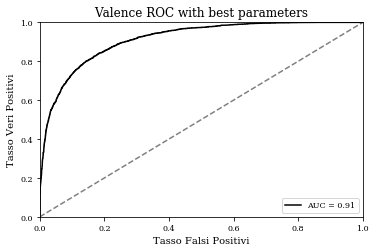

In [12]:
## PLOT ROC CURVE FOR RANDOM FOREST WITH BEST PARAMETER

fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(1,1,1)
plt.title('Valence ROC with best parameters')
plt.plot([0, 1], [0, 1],'--', c='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasso Veri Positivi')
plt.xlabel('Tasso Falsi Positivi')

fpr, tpr, auc = roc_auc["fpr"], roc_auc["tpr"], roc_auc["auc"]
ax.plot(fpr, tpr, 'k-', label = 'AUC = %0.2f' % (auc))

plt.legend(loc = 'lower right')
fig.savefig("ROC_RF_best_val.pdf", format="pdf", bbox_inches='tight')
plt.show()


## Recursive feature selection

In [13]:
classifier, cv = create_classifier(best_params)
rfecv = RFECV(estimator=classifier, step=1, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

In [14]:
rfecv.fit(X, Y)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 25 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.3s finished


Fitting estimator with 24 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.7s finished


Fitting estimator with 23 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.7s finished


Fitting estimator with 22 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 21 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.7s finished


Fitting estimator with 20 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 19 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 18 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 17 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.5s finished


RFECV(cv=StratifiedShuffleSplit(n_splits=5, random_state=7, test_size=0.2,
            train_size=None),
   estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.01,
            min_samples_split=0.01, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=-1, oob_score=False, random_state=7,
            verbose=True, warm_start=False),
   min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
   verbose=1)

In [15]:
dict(zip(X.columns[rfecv.get_support()], rfecv.estimator_.feature_importances_))

{'ECG_max': 0.04187534657203852,
 'ECG_mean': 0.04735556910897141,
 'ECG_mean_diff': 0.06220581502931463,
 'ECG_min': 0.04983726857424463,
 'EDA_max': 0.05751393895250263,
 'EDA_mean': 0.02342261039803295,
 'EDA_mean_diff': 0.05704903183162669,
 'EDA_min': 0.037749169272919145,
 'Resp_max': 0.09085843651411984,
 'Resp_mean_abs_diff': 0.0516765502762236,
 'SKT_max': 0.08998214187382593,
 'SKT_mean': 0.0694988005609464,
 'SKT_mean_abs_diff': 0.05813959129821952,
 'SKT_mean_diff': 0.1605374301248005,
 'SKT_min': 0.036403775300134174,
 'SKT_std': 0.06589452431207943}

In [16]:
print("Optimal number of features : %d" % rfecv.n_features_)
print
print("Accuracy: %.2f%% (%.2f%%)" % (rfecv.grid_scores_[rfecv.n_features_ - 1]*100, 0))

Optimal number of features : 16

Accuracy: 91.87% (0.00%)


/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


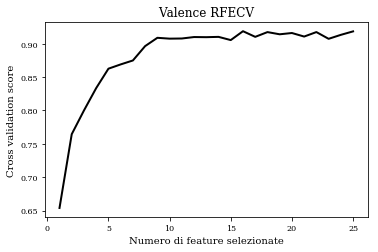

In [17]:
# Plot number of features VS. cross-validation scores
nfeature = range(1, X.shape[1]+1)
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Valence RFECV")
ax.set_xlabel("Numero di feature selezionate")
ax.set_ylabel("Cross validation score")
ax.plot(nfeature, rfecv.grid_scores_, color='K', lw=2)
#ax.vlines([rfecv.n_features_], min(rfecv.grid_scores_), max(rfecv.grid_scores_), colors='gray', linestyles="dotted")
fig.show()
fig.savefig("rfecv_val.pdf", format="pdf", bbox_inches='tight')

In [18]:
# GENERATE ROC FOR RFECV
classifier, cv = create_classifier(best_params) 

scores_train = []
scores_test = []
roc_auc = {}

for train_index, test_index in cv.split(X, Y):

    x_train, y_train = rfecv.transform(X)[train_index], Y.iloc[train_index]
    x_test, y_test = rfecv.transform(X)[test_index], Y.iloc[test_index]

    classifier.fit(x_train, y_train)
    
    y_test_pred = classifier.predict_proba(x_test)
    
    #Keep Probabilities of the positive class only.
    y_test_pred = y_test_pred[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
    
    roc_auc = {
        "fpr" : fpr,
        "tpr" : tpr,
        "auc" : roc_auc_score(y_test, y_test_pred) 
    }

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.4s fi

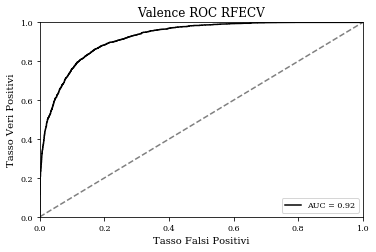

In [19]:
## PLOT ROC CURVE FOR RFECV

fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(1,1,1)
plt.title('Valence ROC RFECV')
plt.plot([0, 1], [0, 1],'--', c='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasso Veri Positivi')
plt.xlabel('Tasso Falsi Positivi')

fpr, tpr, auc = roc_auc["fpr"], roc_auc["tpr"], roc_auc["auc"]
ax.plot(fpr, tpr, 'k-', label = 'AUC = %0.2f' % (auc))

plt.legend(loc = 'lower right')
fig.savefig("ROC_RFECV_val.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Use RFE to stop at a given number of feature

In [20]:
# find number of feature given t = 0.02
t = 0.02
best_score = max(rfecv.grid_scores_)
for i, score in reversed(list(enumerate(rfecv.grid_scores_[:-1], 1))):
    if best_score - score >= t:
        break
print i, score

8 0.896393951877626


In [21]:
classifier, cv = create_classifier(best_params)

# Initialize RFE object
rfe = RFE(classifier, n_features_to_select=8, step=1, verbose=1)

# Fit RFE
rfe.fit(X, np.ravel(Y))

Fitting estimator with 25 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.0s finished


Fitting estimator with 24 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 23 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 22 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 21 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 20 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 19 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 18 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 17 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 16 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.6s finished


Fitting estimator with 15 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


Fitting estimator with 14 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


Fitting estimator with 13 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


Fitting estimator with 12 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


Fitting estimator with 11 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


Fitting estimator with 10 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


Fitting estimator with 9 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.01,
            min_samples_split=0.01, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=-1, oob_score=False, random_state=7,
            verbose=True, warm_start=False),
  n_features_to_select=8, step=1, verbose=1)

In [22]:
# Get selected features labels
feature_names = X.columns
selected_features_rfe = feature_names[rfe.support_].tolist()

In [23]:
print dict(zip(selected_features_rfe, rfe.estimator_.feature_importances_))

{'SKT_max': 0.10169359450534807, 'SKT_mean': 0.11325857066775111, 'EDA_max': 0.10019283401540259, 'ECG_mean': 0.09807427940190522, 'Resp_mean_abs_diff': 0.08552687316999075, 'Resp_max': 0.1125862221908211, 'SKT_std': 0.14247407405782794, 'SKT_mean_diff': 0.2461935519909532}


In [24]:
# GENERATE ROC FOR RFE with manually selected number of feature 
classifier, cv = create_classifier(best_params) 

scores_train = []
scores_test = []
roc_auc = {}

for train_index, test_index in cv.split(X, Y):

    x_train, y_train = rfe.transform(X)[train_index], Y.iloc[train_index]
    x_test, y_test = rfe.transform(X)[test_index], Y.iloc[test_index]

    classifier.fit(x_train, y_train)
    
    y_test_pred = classifier.predict_proba(x_test)
    
    #Keep Probabilities of the positive class only.
    y_test_pred = y_test_pred[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
    
    roc_auc = {
        "fpr" : fpr,
        "tpr" : tpr,
        "auc" : roc_auc_score(y_test, y_test_pred) 
    }

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s fi

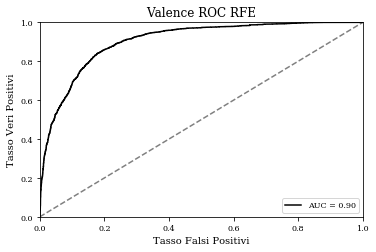

In [25]:
## PLOT ROC CURVE FOR RFE with manually selected number of feature

fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(1,1,1)
plt.title('Valence ROC RFE')
plt.plot([0, 1], [0, 1],'--', c='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasso Veri Positivi')
plt.xlabel('Tasso Falsi Positivi')

fpr, tpr, auc = roc_auc["fpr"], roc_auc["tpr"], roc_auc["auc"]
ax.plot(fpr, tpr, 'k-', label = 'AUC = %0.2f' % (auc))

plt.legend(loc = 'lower right')
fig.savefig("ROC_RFE_val.pdf", format="pdf", bbox_inches='tight')
plt.show()